# Imports

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, Model
from tensorflow.keras.applications import vgg19

2022-12-05 12:45:50.230540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 12:45:50.230553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Testing size, channels, and format of images

In [2]:
rel_path = '../../../data/screenshots/'
legit_path = os.path.join(rel_path, 'legit_screenshots')
scam_path = os.path.join(rel_path, 'scam_screenshots')

In [3]:
def image_shape_check(image_dir):
    
    print('Generating Paths')
    image_paths = []
    for image in os.listdir(image_dir):
        if image.endswith('.png'):
            image_paths.append(os.path.join(image_dir, image))
    
    print('Checking Shapes')
    image_shapes = []
    for image in image_paths:
        np_image = imread(image)
        image_shapes.append(np_image.shape)
    
    print(f'Shapes found: {list(set(image_shapes))}')

In [4]:
# Takes a while to run and will use a lot of memory
# image_shape_check(legit_path)

In [5]:
# Takes a while to run and will use a lot of memory
# image_shape_check(scam_path)

In [6]:
def pillow_check(path, img='3.png'):
    image = Image.open(os.path.join(scam_path, img))
    print(f'Image format: {image.format}')
    print(f'Image size: {image.size}')
    print(f'Image channels: {image.mode}')

In [7]:
pillow_check(legit_path, '5.png')

Image format: PNG
Image size: (800, 600)
Image channels: RGBA


In [8]:
pillow_check(scam_path, '5.png')

Image format: PNG
Image size: (800, 600)
Image channels: RGBA


In [9]:
# we don't need the alpha channel of the image

# Loading Data

In [10]:
# Adapted from W6-D3-C2
# Memory intensive - may not work locally

def load_data():
    
    rel_path = '../../../data/screenshots'
    legit_dir_path = os.path.join(rel_path, 'legit_screenshots')
    scam_dir_path = os.path.join(rel_path, 'scam_screenshots')
    
    # Legit paths
    legit_image_paths = []
    for im_file in os.listdir(legit_dir_path):
        if im_file.endswith('.png'):
            legit_image_paths.append(os.path.join(legit_dir_path, im_file))
    
    # Scam paths
    scam_image_paths = []
    for im_file in os.listdir(scam_dir_path):
        if im_file.endswith('.png'):
            scam_image_paths.append(os.path.join(scam_dir_path, im_file))
    
    X, y = [], []
    print('Importing legit images')
    for legit_image in legit_image_paths:
        np_legit_image = imread(legit_image)[:, :, :3] # slice off the alpha channel
        resized_image = tf.image.resize(np_legit_image, (300, 400))
        X.append(resized_image)
        y.append(0)
    
    print('Importing scam images')
    for scam_image in scam_image_paths:
        np_scam_image = imread(scam_image)[:, :, :3] # slice off the alpha channel
        resized_image = tf.image.resize(np_scam_image, (300, 400))
        X.append(resized_image)
        y.append(1)
    
    print('Finished importing')
    
    print('\nShuffling Data')
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
    
    return np.array(X), np.array(y)

In [11]:
X, y = load_data()

Importing legit images


2022-12-05 12:45:51.877209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 12:45:51.877227: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 12:45:51.877242: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2022-12-05 12:45:51.877776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importing scam images
Finished importing

Shuffling Data


In [12]:
X.shape

(4241, 300, 400, 3)

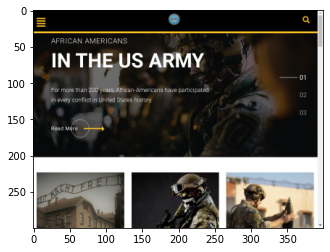

In [13]:
plt.imshow(X[1])

# Sequential Model

In [14]:
# Architecture

def create_model(use_vgg=False):
    if not use_vgg:
        model = models.Sequential([
            layers.Conv2D(16, (4, 4), activation='relu', input_shape=X.shape[1:]),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            layers.Conv2D(16, (4, 4), activation='relu'),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            layers.Conv2D(16, (4, 4), activation='relu'),
            layers.MaxPool2D(2, 2),
            layers.BatchNormalization(),

            # layers.Conv2D(64, (2, 2), activation='relu'),
            # layers.MaxPool2D(2, 2),
            # layers.BatchNormalization(),

            layers.Flatten(),

            layers.Dense(64, activation='relu'),
            # layers.Dropout(0.7),
            layers.Dense(32, activation='relu'),
            # layers.Dropout(0.7),
            layers.Dense(16, activation='relu'),
            # layers.Dropout(0.7),

            layers.Dense(1, activation='sigmoid')
        ])
    else:
        vgg_model = vgg19.VGG19(include_top=False, input_shape=X.shape[1:])
        vgg_model.trainable = False
        
        model = models.Sequential([
            vgg_model,
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
    
    return model

def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
model = create_model()
model = compile_model(model)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 397, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 198, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 148, 198, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 195, 16)      4112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 97, 16)       0         
 2D)                                                             
                                                        

In [ ]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X,
    y,
    epochs=50,
    validation_split=0.3,
    batch_size=16,
    callbacks=[es]
)

2022-12-05 12:47:16.921506: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4273920000 exceeds 10% of free system memory.


Epoch 1/50
186/186 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.5482

2022-12-05 12:49:02.181115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1833120000 exceeds 10% of free system memory.


186/186 [==============================] - 106s 564ms/step - loss: 0.8968 - accuracy: 0.5482 - val_loss: 0.7610 - val_accuracy: 0.5255
Epoch 2/50
186/186 [==============================] - 95s 512ms/step - loss: 0.7089 - accuracy: 0.6034 - val_loss: 0.7109 - val_accuracy: 0.5232
Epoch 3/50
186/186 [==============================] - 98s 529ms/step - loss: 0.6822 - accuracy: 0.6001 - val_loss: 1.0548 - val_accuracy: 0.5302
Epoch 4/50
186/186 [==============================] - 97s 524ms/step - loss: 0.6714 - accuracy: 0.6223 - val_loss: 0.6841 - val_accuracy: 0.6017
Epoch 5/50
186/186 [==============================] - 99s 534ms/step - loss: 0.6236 - accuracy: 0.6594 - val_loss: 0.6689 - val_accuracy: 0.5719
Epoch 6/50
186/186 [==============================] - 100s 539ms/step - loss: 0.5674 - accuracy: 0.7072 - val_loss: 0.8909 - val_accuracy: 0.5271
Epoch 7/50
186/186 [==============================] - 99s 531ms/step - loss: 0.4957 - accuracy: 0.7672 - val_loss: 0.7175 - val_accuracy: 0

# Functional Model

In [ ]:
from tensorflow.keras import layers, models, callbacks, Model

# CNN Architecture
cnn_input = layers.Input(shape=X.shape[1:])

x = layers.Conv2D(16, (4, 4), activation='relu')(cnn_input)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (4, 4), activation='relu')(x)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(16, (4, 4), activation='relu')(x)
x = layers.MaxPool2D(2, 2)(x)
x = layers.BatchNormalization()(x)

cnn_output = layers.Flatten()(x)

In [ ]:
# Define NLP Architecture here

In [ ]:
# Define NLP model and concatenate output
combined = layers.concatenate([cnn_output, nlp_output])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)

final_output = layers.Dense(1, activation='sigmoid')(z)

model = Model(cnn_input, output)

In [ ]:
model.summary()

In [ ]:
model = compile_model(model)

history = model.fit(
    X,
    y,
    epochs=25,
    batch_size=16,
    validation_split=0.3,
    callbacks=callbacks.EarlyStopping(patience=10, restore_best_weights=True)
)